In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import numpy as np
import os
import glob
from tqdm import tqdm
import gc

import torchvision
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from fastai.vision.all import *
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
SEED = 5
FOLDS = [1,2,3,4,5]
PATH = 'C:/Users/TCrepin/perso/Projects/RSNA-Lumbar-Spine-Conditions-Severity-Prediction/' # Main path
DATA_PATH = PATH + 'dataset/' # Data folder
TRAIN_PATH = DATA_PATH + 'train_images/'# Training images folder
ENCODER_NAME = "resnet18"
PATCH_H = 512
PATCH_W = 512
ANGLE = 30
S2 = 64
BS = 16
LR = 1e-4
EPOCHS = 1
TH = .5

In [3]:
S2 = torch.as_tensor(S2)
A = -1/(2*S2).to(device)

In [4]:
train = pd.read_csv(os.path.join(DATA_PATH, 'train_split.csv'))
train.tail()

study_id spinal_canal_stenosis_l1_l2 spinal_canal_stenosis_l2_l3  \
1970  4282019580                 Normal/Mild                 Normal/Mild   
1971  4283570761                 Normal/Mild                 Normal/Mild   
1972  4284048608                 Normal/Mild                 Normal/Mild   
1973  4287160193                 Normal/Mild                    Moderate   
1974  4290709089                 Normal/Mild                 Normal/Mild   

     spinal_canal_stenosis_l3_l4 spinal_canal_stenosis_l4_l5  \
1970                 Normal/Mild                 Normal/Mild   
1971                 Normal/Mild                 Normal/Mild   
1972                 Normal/Mild                      Severe   
1973                 Normal/Mild                 Normal/Mild   
1974                 Normal/Mild                 Normal/Mild   

     spinal_canal_stenosis_l5_s1 left_neural_foraminal_narrowing_l1_l2  \
1970                 Normal/Mild                           Normal/Mild   
1971                 Normal/Mild                           Normal/Mild   
1972                 Normal/Mild                           Normal/Mild   
1973                 Normal/Mild                           Normal/Mild   
1974                 Normal/Mild                           Normal/Mild   

     left_neural_foraminal_narrowing_l2_l3  \
1970                           Normal/Mild   
1971                           Normal/Mild   
1972                           Normal/Mild   
1973                           Normal/Mild   
1974                           Normal/Mild   

     left_neural_foraminal_narrowing_l3_l4  \
1970                           Normal/Mild   
1971                           Normal/Mild   
1972                           Normal/Mild   
1973                           Normal/Mild   
1974                           Normal/Mild   

     left_neural_foraminal_narrowing_l4_l5  ...  \
1970                              Moderate  ...   
1971                           Normal/Mild  ...   
1972                           Normal/Mild  ...   
1973                              Moderate  ...   
1974                           Normal/Mild  ...   

     left_subarticular_stenosis_l2_l3 left_subarticular_stenosis_l3_l4  \
1970                      Normal/Mild                      Normal/Mild   
1971                      Normal/Mild                      Normal/Mild   
1972                      Normal/Mild                      Normal/Mild   
1973                           Severe                         Moderate   
1974                      Normal/Mild                      Normal/Mild   

     left_subarticular_stenosis_l4_l5 left_subarticular_stenosis_l5_s1  \
1970                         Moderate                      Normal/Mild   
1971                      Normal/Mild                      Normal/Mild   
1972                           Severe                      Normal/Mild   
1973                         Moderate                      Normal/Mild   
1974                      Normal/Mild                      Normal/Mild   

     right_subarticular_stenosis_l1_l2 right_subarticular_stenosis_l2_l3  \
1970                       Normal/Mild                       Normal/Mild   
1971                       Normal/Mild                       Normal/Mild   
1972                       Normal/Mild                       Normal/Mild   
1973                       Normal/Mild                       Normal/Mild   
1974                       Normal/Mild                       Normal/Mild   

     right_subarticular_stenosis_l3_l4 right_subarticular_stenosis_l4_l5  \
1970                          Moderate                          Moderate   
1971                       Normal/Mild                       Normal/Mild   
1972                       Normal/Mild                            Severe   
1973                          Moderate                          Moderate   
1974                       Normal/Mild                       Normal/Mild   

     right_subarticular_stenosis_l5_s1 fold  
1970      

In [5]:
df_coor = pd.read_csv(os.path.join(DATA_PATH, 'train_label_coordinates.csv'))
df_coor.tail()

study_id   series_id  instance_number  \
48687  4290709089  4237840455               11   
48688  4290709089  4237840455               12   
48689  4290709089  4237840455               12   
48690  4290709089  4237840455               12   
48691  4290709089  4237840455               12   

                             condition  level           x           y  
48687  Left Neural Foraminal Narrowing  L1/L2  219.465940   97.831063  
48688  Left Neural Foraminal Narrowing  L2/L3  205.340599  140.207084  
48689  Left Neural Foraminal Narrowing  L3/L4  202.724796  181.013624  
48690  Left Neural Foraminal Narrowing  L4/L5  202.933333  219.733333  
48691  Left Neural Foraminal Narrowing  L5/S1  211.813953  259.534884

In [6]:
S = df_coor[
    df_coor['condition'] == 'Spinal Canal Stenosis'
].sort_values([
    'study_id',
    'series_id',
    'level'
]).reset_index(drop=True)
S.tail()

study_id   series_id  instance_number              condition  level  \
9748  4290709089  3274612423                9  Spinal Canal Stenosis  L1/L2   
9749  4290709089  3274612423                9  Spinal Canal Stenosis  L2/L3   
9750  4290709089  3274612423                9  Spinal Canal Stenosis  L3/L4   
9751  4290709089  3274612423                9  Spinal Canal Stenosis  L4/L5   
9752  4290709089  3274612423                9  Spinal Canal Stenosis  L5/S1   

               x           y  
9748  181.668947   88.864569  
9749  174.227086  125.198358  
9750  174.227086  160.656635  
9751  182.544460  191.299590  
9752  194.363885  218.878249

In [7]:
S['x_mean_fraction'] = S['x']/S.groupby(['study_id','series_id'])['x'].mean().loc[[(study_id,series_id) for study_id,series_id in S[['study_id','series_id']].values]].values
S.tail()

study_id   series_id  instance_number              condition  level  \
9748  4290709089  3274612423                9  Spinal Canal Stenosis  L1/L2   
9749  4290709089  3274612423                9  Spinal Canal Stenosis  L2/L3   
9750  4290709089  3274612423                9  Spinal Canal Stenosis  L3/L4   
9751  4290709089  3274612423                9  Spinal Canal Stenosis  L4/L5   
9752  4290709089  3274612423                9  Spinal Canal Stenosis  L5/S1   

               x           y  x_mean_fraction  
9748  181.668947   88.864569         1.001448  
9749  174.227086  125.198358         0.960425  
9750  174.227086  160.656635         0.960425  
9751  182.544460  191.299590         1.006274  
9752  194.363885  218.878249         1.071429

{'whiskers': [<matplotlib.lines.Line2D at 0x21b834ccec8>,
 'caps': [<matplotlib.lines.Line2D at 0x21b87e4cc48>,
 'boxes': [<matplotlib.lines.Line2D at 0x21b87e3bbc8>],
 'medians': [<matplotlib.lines.Line2D at 0x21b87e55588>],
 'fliers': [<matplotlib.lines.Line2D at 0x21b87e55a48>],
 'means': []}

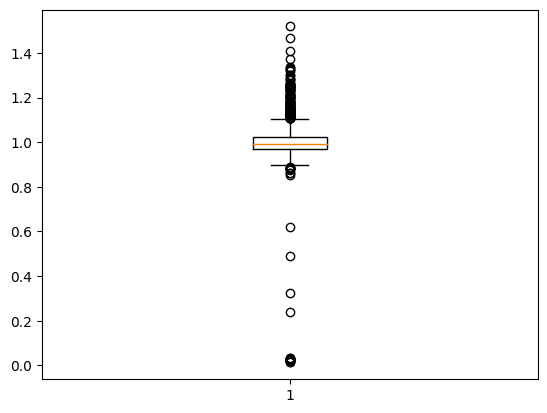

In [8]:
plt.boxplot(S['x_mean_fraction'])

In [9]:
S[S['x_mean_fraction'] < .8]

study_id   series_id  instance_number              condition  level  \
64      38281420   880361156                9  Spinal Canal Stenosis  L5/S1   
656    283265383   221289021               10  Spinal Canal Stenosis  L5/S1   
661    286903519  1921917205               13  Spinal Canal Stenosis  L5/S1   
1475   665627263  2231471633                9  Spinal Canal Stenosis  L1/L2   
3217  1438760543   737753815                9  Spinal Canal Stenosis  L1/L2   
3379  1510451897  1488857550                9  Spinal Canal Stenosis  L4/L5   
4067  1820866003   131094096                7  Spinal Canal Stenosis  L2/L3   
4223  1880970480  3736941525                8  Spinal Canal Stenosis  L5/S1   
4261  1901348744  1490272456               11  Spinal Canal Stenosis  L3/L4   
4384  1973833645   833708507               15  Spinal Canal Stenosis  L1/L2   
4789  2151467507  3086719329                8  Spinal Canal Stenosis  L3/L4   
4795  2151509334  3072714332                9  Spinal Canal Stenosis  L4/L5   
5130  2316015842  1485193299               13  Spinal Canal Stenosis  L1/L2   
5456  2444340715  3521409198               10  Spinal Canal Stenosis  L5/S1   
5528  2480600394  2969009171               12  Spinal Canal Stenosis  L2/L3   
6585  2905025904   816381378               11  Spinal Canal Stenosis  L1/L2   
8632  3819260179  1735851779                7  Spinal Canal Stenosis  L5/S1   

               x           y  x_mean_fraction  
64      5.000000    5.000000         0.032722  
656    71.800000   71.300000         0.620898  
661     5.000007    5.000007         0.019846  
1475    5.000000    5.000000         0.013212  
3217    5.000042    4.999993         0.026057  
3379    5.000000    4.999982         0.034348  
4067    5.000000    2.063098         0.022388  
4223    5.000000    5.000000         0.024127  
4261    4.999947    4.999971         0.018048  
4384  187.590245  351.529052         0.489658  
4789    4.058824    5.000000         0.016656  
4795    5.978967    4.021033         0.024476  
5130    5.000029    5.000007         0.029660  
5456    5.000029    4.999986         0.027638  
5528   41.039548  174.282486         0.238054  
6585    4.999978    4.999999         0.029955  
8632   73.647059  453.176471         0.323729

In [10]:
S = S[S['x_mean_fraction'] > .8]

In [11]:
coordinates = {}
for i in range(len(S)):
    row = S.iloc[i]
    coordinates[row['study_id']] = {}
for i in range(len(S)):
    row = S.iloc[i]
    coordinates[row['study_id']][row['series_id']] = {}
for i in range(len(S)):
    row = S.iloc[i]
    coordinates[row['study_id']][row['series_id']][row['instance_number']] = {
        'L1/L2':{
            'x':torch.nan,
            'y':torch.nan
        },
        'L2/L3':{
            'x':torch.nan,
            'y':torch.nan
        },
        'L3/L4':{
            'x':torch.nan,
            'y':torch.nan
        },
        'L4/L5':{
            'x':torch.nan,
            'y':torch.nan
        },
        'L5/S1':{
            'x':torch.nan,
            'y':torch.nan
        }
    }
for i in range(len(S)):
    row = S.iloc[i]
    coordinates[row['study_id']][row['series_id']][row['instance_number']][row['level']]['x'] = row['x']
    coordinates[row['study_id']][row['series_id']][row['instance_number']][row['level']]['y'] = row['y']

In [12]:
S =  S[[
    'study_id',
    'series_id',
    'instance_number'
]].groupby([
    'study_id',
    'series_id',
    'instance_number'
]).count().reset_index()
S.tail()

study_id   series_id  instance_number
2514  4283570761   453728183                9
2515  4284048608  3767301072               10
2516  4284048608  3767301072               12
2517  4287160193  1507070277                8
2518  4290709089  3274612423                9

In [13]:
v = np.zeros((len(S),10))
for i in tqdm(range(len(S))):
    row = S.iloc[i]
    k = 0
    for level in coordinates[row['study_id']][row['series_id']][row['instance_number']]:
        v[i,k:k+2] = list(coordinates[row['study_id']][row['series_id']][row['instance_number']][level].values())
        k += 2

  0%|          | 0/2519 [00:00<?, ?it/s]100%|██████████| 2519/2519 [00:00<00:00, 7798.27it/s]


In [14]:
coor = [
    'x_L1L2',
    'y_L1L2',
    'x_L2L3',
    'y_L2L3',
    'x_L3L4',
    'y_L3L4',
    'x_L4L5',
    'y_L4L5',
    'x_L5S1',
    'y_L5S1'    
]

In [15]:
S[coor] = v
S.tail()

study_id   series_id  instance_number      x_L1L2      y_L1L2  \
2514  4283570761   453728183                9  252.096578  148.066797   
2515  4284048608  3767301072               10  290.154631  203.001570   
2516  4284048608  3767301072               12         NaN         NaN   
2517  4287160193  1507070277                8  391.235190  235.644570   
2518  4290709089  3274612423                9  181.668947   88.864569   

          x_L2L3      y_L2L3      x_L3L4      y_L3L4      x_L4L5      y_L4L5  \
2514  239.788300  209.608186  232.427696  265.899924  235.546307  315.797706   
2515  276.591052  269.915228  272.974097  335.020408         NaN         NaN   
2516         NaN         NaN         NaN         NaN  280.208006  391.083203   
2517  369.435472  321.805360  373.587800  391.356841  397.463681  456.755994   
2518  174.227086  125.198358  174.227086  160.656635  182.544460  191.299590   

          x_L5S1      y_L5S1  
2514  254.013013  364.807609  
2515         NaN         NaN  
2516  295.580063  443.529042  
2517  427.568054  516.964739  
2518  194.363885  218.878249

In [16]:
for (study_id,series_id),df in tqdm(S.groupby(['study_id','series_id'])):
    sample = TRAIN_PATH + str(study_id) + '/' + str(series_id)
    instance_numbers = [int(x.replace('\\','/').split('/')[-1].replace('.dcm','')) for x in glob.glob(sample+'/*.dcm')]
    instance_numbers.sort()
    instance_numbers = np.array(instance_numbers)
    D = len(instance_numbers)
    L = D//3
    FIRST = int(np.arange(D)[instance_numbers == df['instance_number'].min()])
    LAST = int(np.arange(D)[instance_numbers == df['instance_number'].max()])
    M = (FIRST + LAST)//2
    START = max([0,M - L//2])
    END = min([D,M+L-L//2+1])
    new = instance_numbers[START:END].tolist()
    if FIRST > 0: new.append(instance_numbers[FIRST - 1])
    if FIRST > 1: new.append(instance_numbers[FIRST - 2])
    if LAST < D - 1: new.append(instance_numbers[LAST + 1])
    if LAST < D - 2: new.append(instance_numbers[LAST + 2])
    L = len(new)
    S = pd.concat([
            S,
            pd.DataFrame({
                'study_id':[int(study_id)]*L,
                'series_id':[int(series_id)]*L,
                'instance_number':new,
                'x_L1L2':[torch.nan]*L,
                'y_L1L2':[torch.nan]*L,
                'x_L2L3':[torch.nan]*L,
                'y_L2L3':[torch.nan]*L,
                'x_L3L4':[torch.nan]*L,
                'y_L3L4':[torch.nan]*L,
                'x_L4L5':[torch.nan]*L,
                'y_L4L5':[torch.nan]*L,
                'x_L5S1':[torch.nan]*L,
                'y_L5S1':[torch.nan]*L
            })
        ])
    

100%|██████████| 1974/1974 [00:02<00:00, 669.06it/s]


In [17]:
S = S.reset_index(drop=True)
S[['study_id','series_id','instance_number']] = S[['study_id','series_id','instance_number']].astype(np.int64)
S.tail()

study_id   series_id  instance_number  x_L1L2  y_L1L2  x_L2L3  \
23102  4290709089  3274612423               12     NaN     NaN     NaN   
23103  4290709089  3274612423                8     NaN     NaN     NaN   
23104  4290709089  3274612423                7     NaN     NaN     NaN   
23105  4290709089  3274612423               10     NaN     NaN     NaN   
23106  4290709089  3274612423               11     NaN     NaN     NaN   

       y_L2L3  x_L3L4  y_L3L4  x_L4L5  y_L4L5  x_L5S1  y_L5S1  
23102     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
23103     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
23104     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
23105     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
23106     NaN     NaN     NaN     NaN     NaN     NaN     NaN

In [18]:
S_mean = S.groupby(['study_id','series_id']).mean()
S_mean.tail()

instance_number      x_L1L2      y_L1L2      x_L2L3  \
study_id   series_id                                                         
4282019580 1547999333        11.307692  217.588235  104.823529  202.305085   
4283570761 453728183          9.000000  252.096578  148.066797  239.788300   
4284048608 3767301072        11.285714  290.154631  203.001570  276.591052   
4287160193 1507070277         8.272727  391.235190  235.644570  369.435472   
4290709089 3274612423         9.272727  181.668947   88.864569  174.227086   

                           y_L2L3      x_L3L4      y_L3L4      x_L4L5  \
study_id   series_id                                                    
4282019580 1547999333  151.864407  196.411765  193.764706  203.470588   
4283570761 453728183   209.608186  232.427696  265.899924  235.546307   
4284048608 3767301072  269.915228  272.974097  335.020408  280.208006   
4287160193 1507070277  321.805360  373.587800  391.356841  397.463681   
4290709089 3274612423  125.198358  174.227086  160.656635  182.544460   

                           y_L4L5      x_L5S1      y_L5S1  
study_id   series_id                                       
4282019580 1547999333  241.058824  214.058824  274.235294  
4283570761 453728183   315.797706  254.013013  364.807609  
4284048608 3767301072  391.083203  295.580063  443.529042  
4287160193 1507070277  456.755994  427.568054  516.964739  
4290709089 3274612423  191.299590  194.363885  218.878249

In [19]:
S_mean = S_mean.loc[[(study_id,series_id) for study_id,series_id in S[['study_id','series_id']].values]][coor].values
S_mean.shape

(23107, 10)

In [20]:
S_values = S[coor].values
S_values.shape

(23107, 10)

In [21]:
mask = S[coor].isna()
mask.shape

(23107, 10)

In [22]:
S_values[mask] = S_mean[mask]
S[coor] = S_values
S.tail()

study_id   series_id  instance_number      x_L1L2     y_L1L2  \
23102  4290709089  3274612423               12  181.668947  88.864569   
23103  4290709089  3274612423                8  181.668947  88.864569   
23104  4290709089  3274612423                7  181.668947  88.864569   
23105  4290709089  3274612423               10  181.668947  88.864569   
23106  4290709089  3274612423               11  181.668947  88.864569   

           x_L2L3      y_L2L3      x_L3L4      y_L3L4     x_L4L5     y_L4L5  \
23102  174.227086  125.198358  174.227086  160.656635  182.54446  191.29959   
23103  174.227086  125.198358  174.227086  160.656635  182.54446  191.29959   
23104  174.227086  125.198358  174.227086  160.656635  182.54446  191.29959   
23105  174.227086  125.198358  174.227086  160.656635  182.54446  191.29959   
23106  174.227086  125.198358  174.227086  160.656635  182.54446  191.29959   

           x_L5S1      y_L5S1  
23102  194.363885  218.878249  
23103  194.363885  218.878249  
23104  194.363885  218.878249  
23105  194.363885  218.878249  
23106  194.363885  218.878249

In [23]:
S[S.isna().sum(1) > 0].reset_index(drop=True).tail()

study_id  series_id  instance_number  x_L1L2  y_L1L2  x_L2L3  y_L2L3  \
1032  4232806580  346177997               10     NaN     NaN     NaN     NaN   
1033  4232806580  346177997                7     NaN     NaN     NaN     NaN   
1034  4232806580  346177997                6     NaN     NaN     NaN     NaN   
1035  4232806580  346177997                9     NaN     NaN     NaN     NaN   
1036  4232806580  346177997               10     NaN     NaN     NaN     NaN   

          x_L3L4      y_L3L4      x_L4L5      y_L4L5      x_L5S1     y_L5S1  
1032  246.113606  237.400264  242.731836  282.715984  263.698811  320.59181  
1033  246.113606  237.400264  242.731836  282.715984  263.698811  320.59181  
1034  246.113606  237.400264  242.731836  282.715984  263.698811  320.59181  
1035  246.113606  237.400264  242.731836  282.715984  263.698811  320.59181  
1036  246.113606  237.400264  242.731836  282.715984  263.698811  320.59181

In [24]:
df_meta_f = pd.read_csv(os.path.join(DATA_PATH,  'train_series_descriptions.csv'))
df_meta_f.tail()

study_id   series_id series_description
6289  4287160193  1507070277   Sagittal T2/STIR
6290  4287160193  1820446240           Axial T2
6291  4290709089  3274612423   Sagittal T2/STIR
6292  4290709089  3390218084           Axial T2
6293  4290709089  4237840455        Sagittal T1

In [25]:
S = S.merge(df_meta_f[['series_id','series_description']], left_on='series_id', right_on='series_id')
S.tail()

study_id   series_id  instance_number      x_L1L2     y_L1L2  \
23102  4290709089  3274612423               12  181.668947  88.864569   
23103  4290709089  3274612423                8  181.668947  88.864569   
23104  4290709089  3274612423                7  181.668947  88.864569   
23105  4290709089  3274612423               10  181.668947  88.864569   
23106  4290709089  3274612423               11  181.668947  88.864569   

           x_L2L3      y_L2L3      x_L3L4      y_L3L4     x_L4L5     y_L4L5  \
23102  174.227086  125.198358  174.227086  160.656635  182.54446  191.29959   
23103  174.227086  125.198358  174.227086  160.656635  182.54446  191.29959   
23104  174.227086  125.198358  174.227086  160.656635  182.54446  191.29959   
23105  174.227086  125.198358  174.227086  160.656635  182.54446  191.29959   
23106  174.227086  125.198358  174.227086  160.656635  182.54446  191.29959   

           x_L5S1      y_L5S1 series_description  
23102  194.363885  218.878249   Sagittal T2/STIR  
23103  194.363885  218.878249   Sagittal T2/STIR  
23104  194.363885  218.878249   Sagittal T2/STIR  
23105  194.363885  218.878249   Sagittal T2/STIR  
23106  194.363885  218.878249   Sagittal T2/STIR

In [26]:
S.groupby('series_description').count()

study_id  series_id  instance_number  x_L1L2  y_L1L2  \
series_description                                                         
Sagittal T1               11         11               11      11      11   
Sagittal T2/STIR       23096      23096            23096   22243   22243   

                    x_L2L3  y_L2L3  x_L3L4  y_L3L4  x_L4L5  y_L4L5  x_L5S1  \
series_description                                                           
Sagittal T1             11      11      11      11      11      11      11   
Sagittal T2/STIR     22633   22633   23063   23063   23055   23055   22983   

                    y_L5S1  
series_description          
Sagittal T1             11  
Sagittal T2/STIR     22983

In [27]:
S = S[S.series_description == 'Sagittal T2/STIR'].reset_index(drop=True)
S.groupby('series_description').count()

study_id  series_id  instance_number  x_L1L2  y_L1L2  \
series_description                                                         
Sagittal T2/STIR       23096      23096            23096   22243   22243   

                    x_L2L3  y_L2L3  x_L3L4  y_L3L4  x_L4L5  y_L4L5  x_L5S1  \
series_description                                                           
Sagittal T2/STIR     22633   22633   23063   23063   23055   23055   22983   

                    y_L5S1  
series_description          
Sagittal T2/STIR     22983

In [28]:
S = S.merge(train[['study_id','fold']],left_on='study_id',right_on='study_id')
S.tail()

study_id   series_id  instance_number      x_L1L2     y_L1L2  \
23091  4290709089  3274612423               12  181.668947  88.864569   
23092  4290709089  3274612423                8  181.668947  88.864569   
23093  4290709089  3274612423                7  181.668947  88.864569   
23094  4290709089  3274612423               10  181.668947  88.864569   
23095  4290709089  3274612423               11  181.668947  88.864569   

           x_L2L3      y_L2L3      x_L3L4      y_L3L4     x_L4L5     y_L4L5  \
23091  174.227086  125.198358  174.227086  160.656635  182.54446  191.29959   
23092  174.227086  125.198358  174.227086  160.656635  182.54446  191.29959   
23093  174.227086  125.198358  174.227086  160.656635  182.54446  191.29959   
23094  174.227086  125.198358  174.227086  160.656635  182.54446  191.29959   
23095  174.227086  125.198358  174.227086  160.656635  182.54446  191.29959   

           x_L5S1      y_L5S1 series_description  fold  
23091  194.363885  218.878249   Sagittal T2/STIR   5.0  
23092  194.363885  218.878249   Sagittal T2/STIR   5.0  
23093  194.363885  218.878249   Sagittal T2/STIR   5.0  
23094  194.363885  218.878249   Sagittal T2/STIR   5.0  
23095  194.363885  218.878249   Sagittal T2/STIR   5.0

In [29]:
S.groupby('fold').count()

study_id  series_id  instance_number  x_L1L2  y_L1L2  x_L2L3  y_L2L3  \
fold                                                                         
1.0       4661       4661             4661    4509    4509    4618    4618   
2.0       4634       4634             4634    4399    4399    4510    4510   
3.0       4576       4576             4576    4416    4416    4431    4431   
4.0       4590       4590             4590    4449    4449    4526    4526   
5.0       4635       4635             4635    4470    4470    4548    4548   

      x_L3L4  y_L3L4  x_L4L5  y_L4L5  x_L5S1  y_L5S1  series_description  
fold                                                                      
1.0     4661    4661    4650    4650    4610    4610                4661  
2.0     4634    4634    4623    4623    4634    4634                4634  
3.0     4551    4551    4565    4565    4553    4553                4576  
4.0     4582    4582    4582    4582    4561    4561                4590  
5.0     4635    4635    4635    4635    4625    4625                4635

In [30]:
def augment_image_and_centers(image,centers,center=(PATCH_H/2,PATCH_W/2)):
    # Randomly rotate the image.
    angle = torch.as_tensor(random.uniform(-ANGLE, ANGLE))
    image = torchvision.transforms.functional.rotate(
        image,angle.item(),
        interpolation=torchvision.transforms.InterpolationMode.BILINEAR,
        center=center
    )
    # https://discuss.pytorch.org/t/rotation-matrix/128260
    angle = -angle*math.pi/180
    s = torch.sin(angle)
    c = torch.cos(angle)
    rot = torch.stack([
        torch.stack([c, s]),
        torch.stack([-s, c])
    ])
    center = torch.as_tensor(center).float()
    centers = ((centers.cpu() - center) @ rot) + center

    return image,centers

torch_resize = torchvision.transforms.Resize((PATCH_H,PATCH_W),antialias=True)

x_map = torch.stack([torch.arange(PATCH_W)]*PATCH_H).float()
y_map = torch.stack([torch.arange(PATCH_H)]*PATCH_W).float()
idx_map = torch.stack([x_map,y_map.T]).view(1,2,PATCH_H,PATCH_W).to(device)

In [31]:
class Sagittal_T2_sagittal_level_Dataset(Dataset):
    def __init__(self, df, VALID=False, alpha=0):
        self.data = df
        self.VALID = VALID
        self.alpha = alpha

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]

        centers = torch.as_tensor([x for x in row[coor]]).view(5,2).float()
        
        sample = TRAIN_PATH + str(row['study_id']) + '/' + str(row['series_id']) + '/'+str(row['instance_number']) + '.dcm'
        
        image = pydicom.dcmread(sample).pixel_array
        H,W = image.shape
#       By plane resizing I've been distorting the proportions
        if H > W:
            d = W
            if not self.VALID:
                h = int((H - d)*(.5 + self.alpha*(.5 - np.random.rand())))
            else:
                h = (H - d)//2
            image = image[h:h+d]
            centers[:,1] -= h
            H = W
        elif H < W:
            d = H
            if not self.VALID:
                w = int((W - d)*(.5 + self.alpha*(.5 - np.random.rand())))
            else:
                w = (W - d)//2
            image = image[:,w:w+d]
            centers[:,0] -= w
            W = H
        image = torch_resize(torch.as_tensor((image/np.max(image)).astype(np.float32)).unsqueeze(0))
        image = image.float().to(device)
        
        centers[:,0] = centers[:,0]*PATCH_W/W
        centers[:,1] = centers[:,1]*PATCH_H/H

        if not self.VALID: image,centers = augment_image_and_centers(image,centers)

        return image,centers

In [32]:
tds = Sagittal_T2_sagittal_level_Dataset(S)

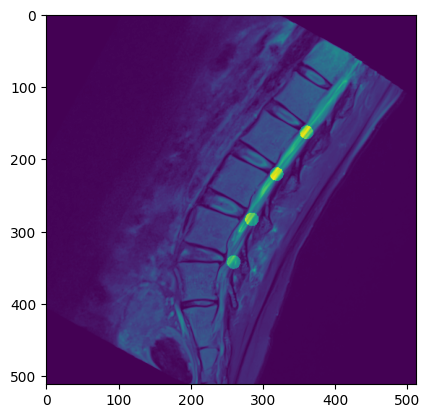

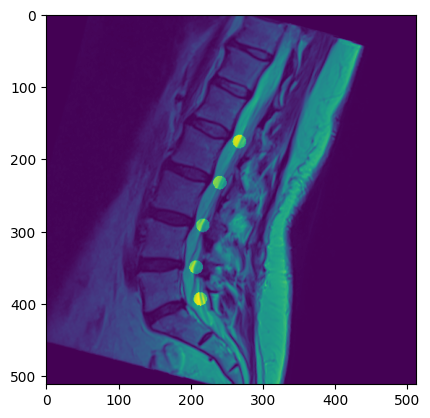

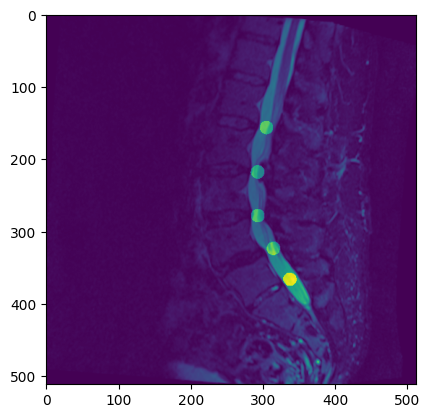

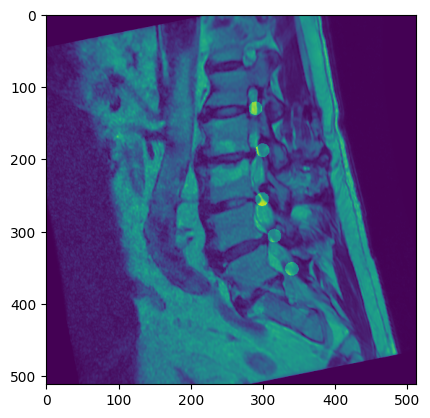

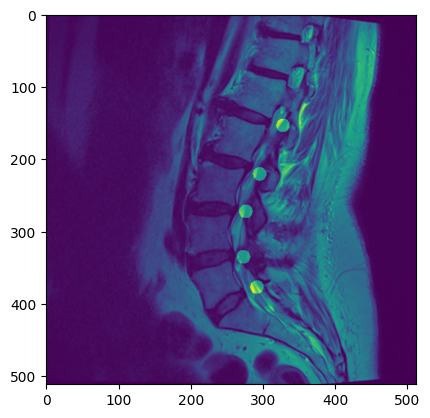

In [33]:
for k in range(5):
    image,centers = tds.__getitem__(np.random.randint(len(tds)))
    centers = centers[centers.isnan().sum(1) == 0]
#   Ideal heatmaps
    mask = idx_map - centers.view(len(centers),2,1,1).to(device)
    mask = (mask*mask).sum(1)
    mask = torch.exp(A*mask)
    mask = mask.sum(0)
    plt.imshow(image.cpu()[0] + .5*(mask.cpu() > TH))
    plt.show()

In [34]:
vds = Sagittal_T2_sagittal_level_Dataset(S,VALID=True)

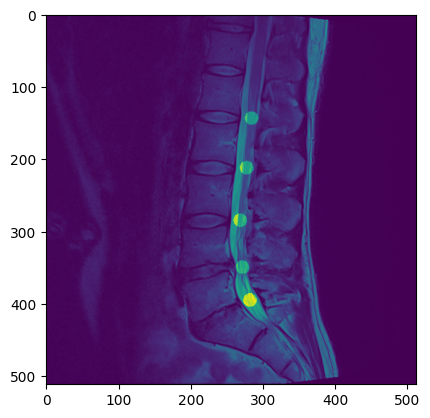

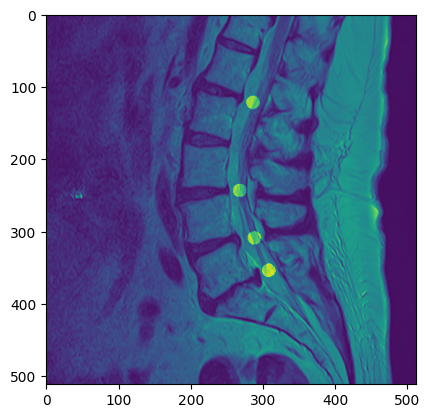

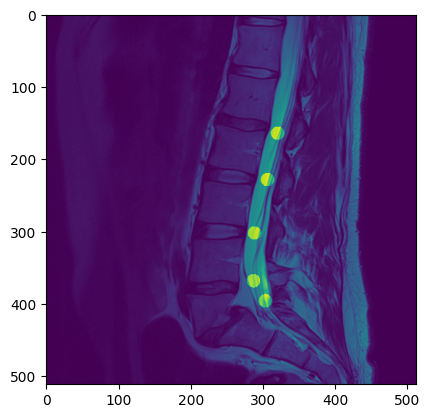

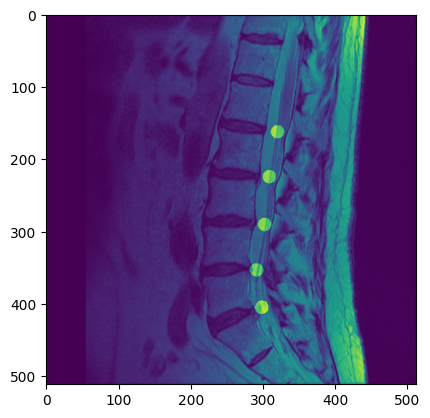

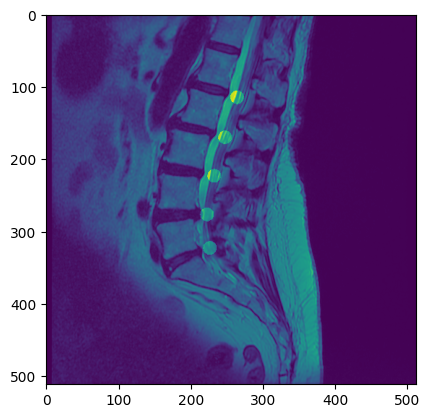

In [35]:
for k in range(5):
    image,centers = vds.__getitem__(np.random.randint(len(tds)))
    centers = centers[centers.isnan().sum(1) == 0]
#   Ideal heatmaps
    mask = idx_map - centers.view(len(centers),2,1,1).to(device)
    mask = (mask*mask).sum(1)
    mask = torch.exp(A*mask)
    mask = mask.sum(0)
    plt.imshow(image.cpu()[0] + .5*(mask.cpu() > TH))
    plt.show()

In [36]:
del tds,vds
gc.collect()

29536

In [37]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [38]:
class myUNet(nn.Module):
    def __init__(
        self,
        classes
        ):
        super(myUNet, self).__init__()

        self.classes = classes
        self.UNet = smp.Unet(
            encoder_name=ENCODER_NAME,
            classes=classes,
            in_channels=1
        ).to(device)

    def forward(self,X):
        H,W = X.shape[-2:]
        x = self.UNet(X.view(-1,1,H,W)).view(-1,H*W)
#       MinMaxScaling along the class plane to generate a heatmap
        min_values = x.min(-1)[0].view(-1,1)
        max_values = x.max(-1)[0].view(-1,1)
        d = (max_values - min_values)
        d[d == 0] = 1
        x = (x - min_values)/d
        
        return x.view(-1,self.classes,H,W)

In [39]:
class myLoss(nn.Module):
    def __init__(
            self,
            alpha=.5,
            smooth = 1e-6
        ):
        super().__init__()
        self.alpha = alpha
        self.smooth = smooth

    def clone(self):
        return myLoss(self.alpha)

    def forward(
            self,
            heatmaps,# Predictions
            centers # Targets
        ):
        H,W = heatmaps.shape[-2:]
        heatmaps = heatmaps.view(-1,H*W)
        centers = centers.view(-1,2)
        m = centers.isnan().sum(1) == 0
        heatmaps = heatmaps[m]
        centers = centers[m]
#       Ideal heatmaps
        mask = idx_map - centers.view(len(centers),2,1,1).to(device)
        mask = (mask*mask).sum(1)
        mask = torch.exp(A*mask)
        mask = mask.view(-1,H*W)
#       Distance
        D = 1 - ((mask*heatmaps).sum(-1))**2/((mask*mask).sum(-1)*(heatmaps*heatmaps).sum(-1)+self.smooth)
        
        return D.mean()

In [40]:
# CosineAnnealingAlpha
def nt(nmin,nmax,tcur,tmax):
    return (nmax - .5*(nmax-nmin)*(1+np.cos(tcur*np.pi/tmax))).astype(np.float32)

#plt.plot(nt(.25,1,np.arange(EPOCHS),EPOCHS))
#plt.show()

# callback to update alpha during training
def cb(self):
    alpha = torch.as_tensor(nt(.25,1,learn.train_iter,EPOCHS*n_iter))
    learn.dls.train_ds.alpha = alpha
alpha_cb = Callback(before_batch=cb)

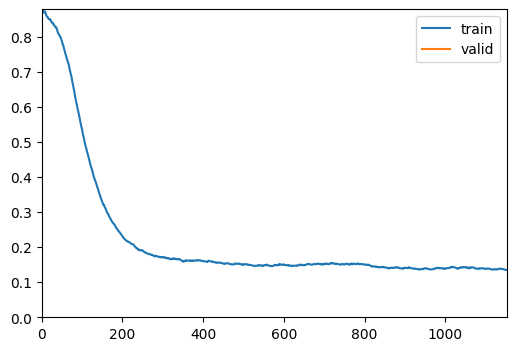

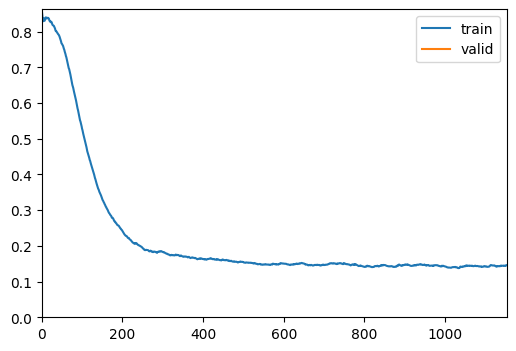

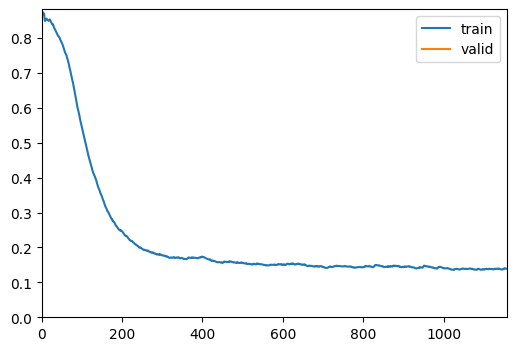

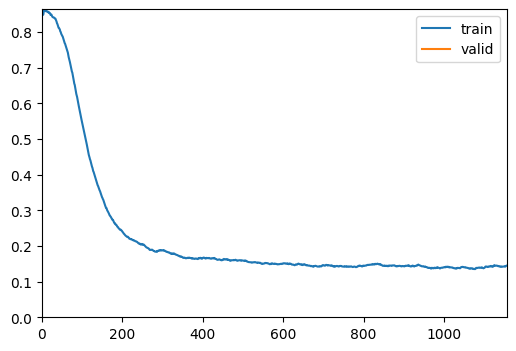

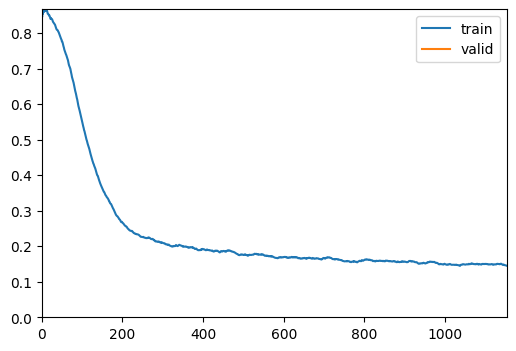

In [41]:
for f in FOLDS:
    seed_everything(SEED)
#   model = myUNet(5)
    model = torch.load(PATH + 'Sagittal_T1/level_segmentation/Sagittal_T1_sagittal_level_segmentation_'+str(f))
    
    tdf = S[S['fold'] != f]
    vdf = S[S['fold'] == f]

    tds = Sagittal_T2_sagittal_level_Dataset(tdf)
    vds = Sagittal_T2_sagittal_level_Dataset(vdf,VALID=True)
    
    tdl = torch.utils.data.DataLoader(tds, batch_size=BS, shuffle=True, drop_last=True)
    vdl = torch.utils.data.DataLoader(vds, batch_size=BS, shuffle=False)

    dls = DataLoaders(tdl,vdl)

    n_iter = len(tds)//BS

    learn = Learner(
        dls,
        model,
        lr=LR,
        loss_func=myLoss(alpha=0.5),
        cbs=[
            ShowGraphCallback(),
            alpha_cb
        ]
    )
    learn.fit_one_cycle(EPOCHS)
    torch.save(model,'Sagittal_T2_sagittal_level_segmentation_'+str(f))
    del tdl,vdl,dls,model,learn
    gc.collect()

In [42]:
f = 1
model = torch.load('Sagittal_T2_sagittal_level_segmentation_'+str(f))
vdf = S[S['fold'] == f]
vds = Sagittal_T2_sagittal_level_Dataset(vdf,VALID=True)

1090


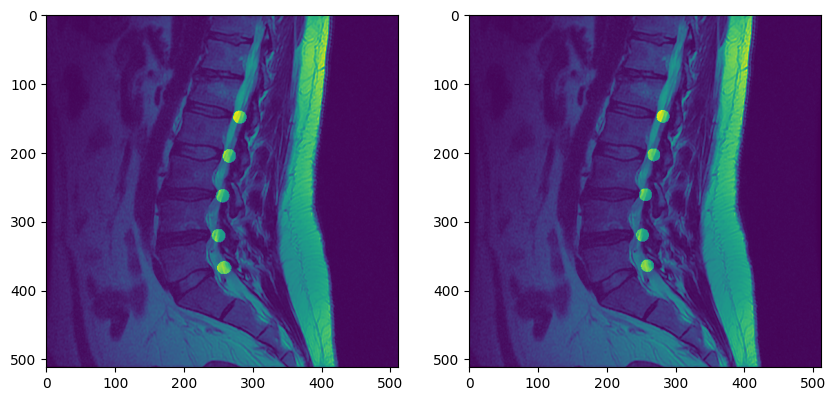

3797


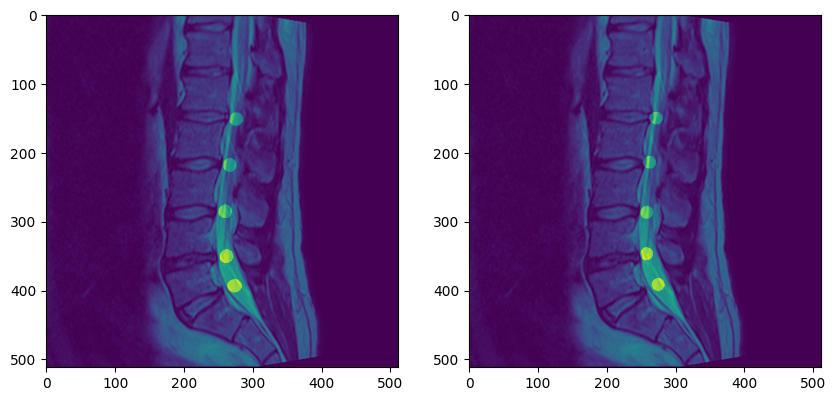

2647


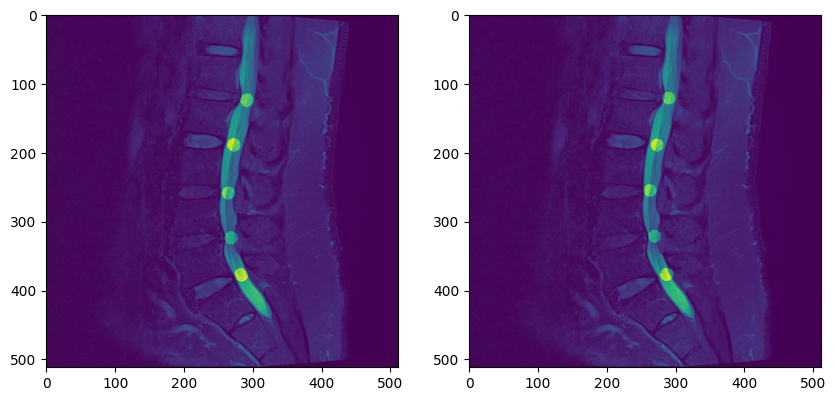

665


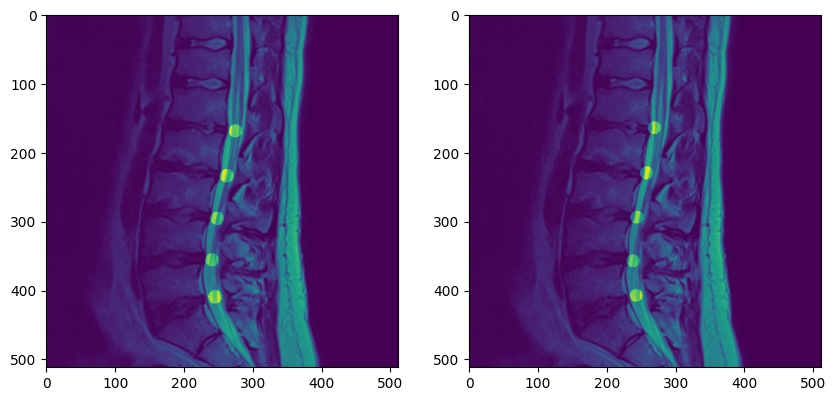

16


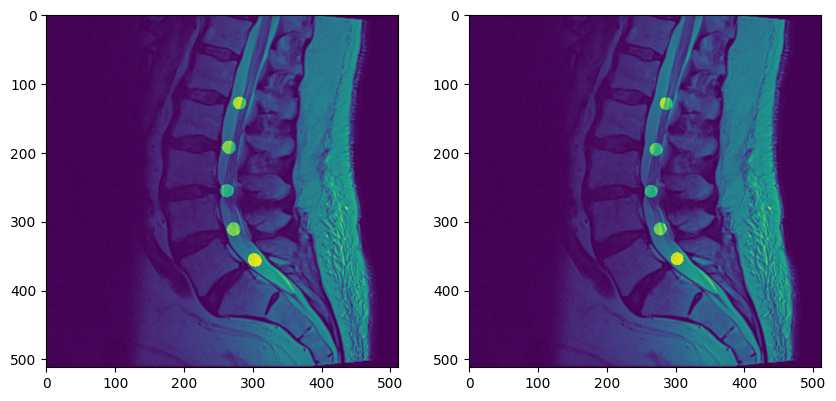

4448


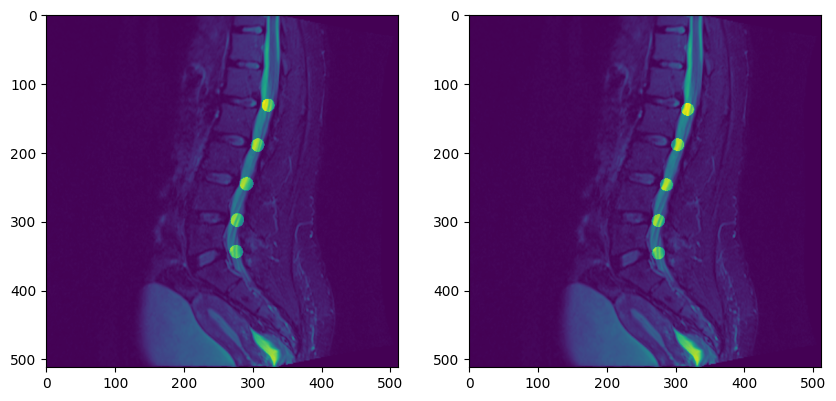

2366


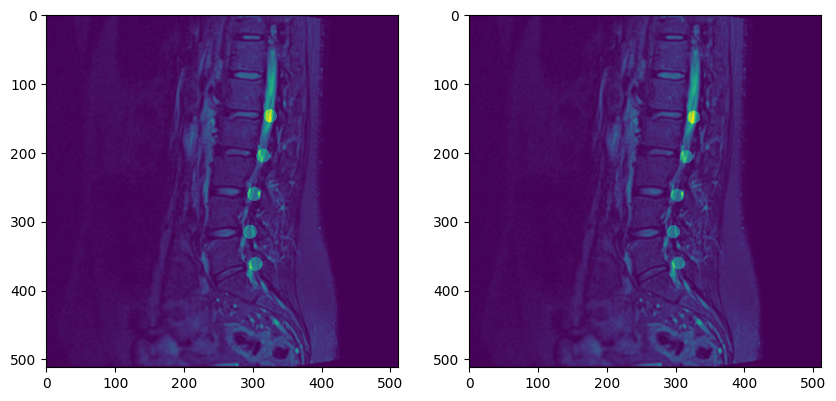

2637


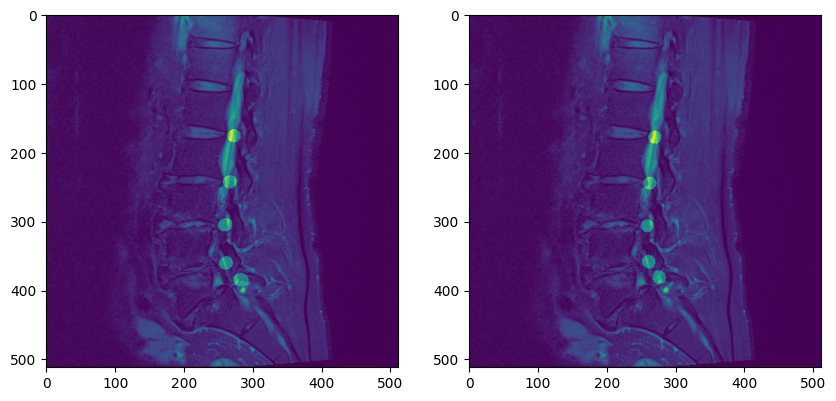

1138


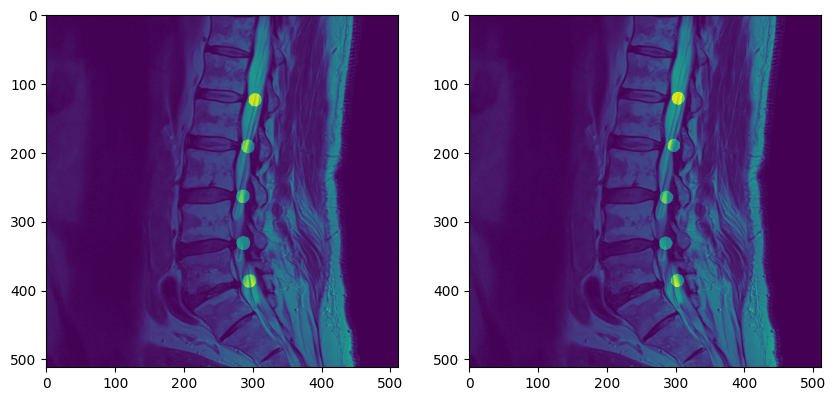

3704


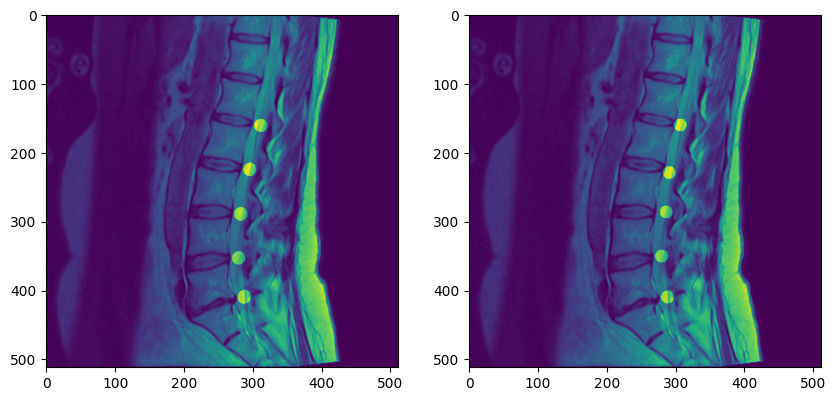

1981


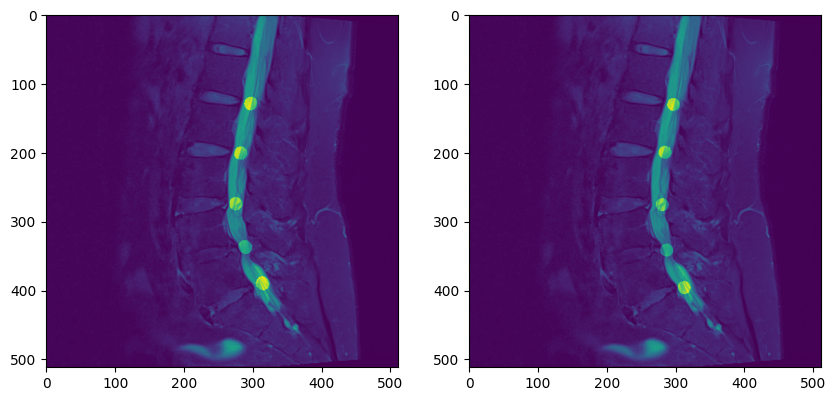

3473


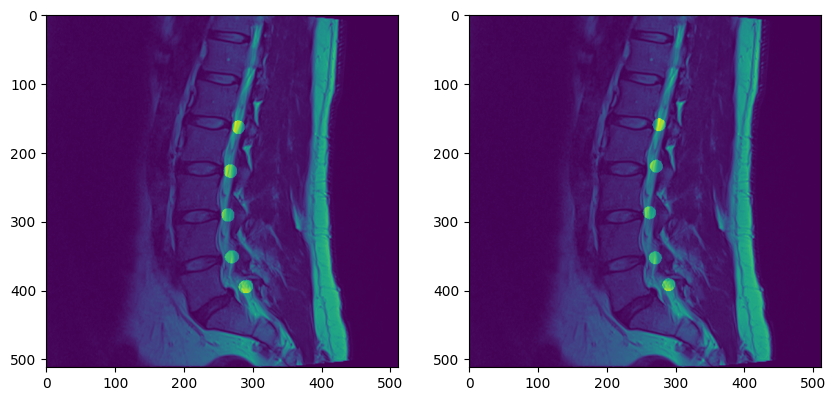

4553


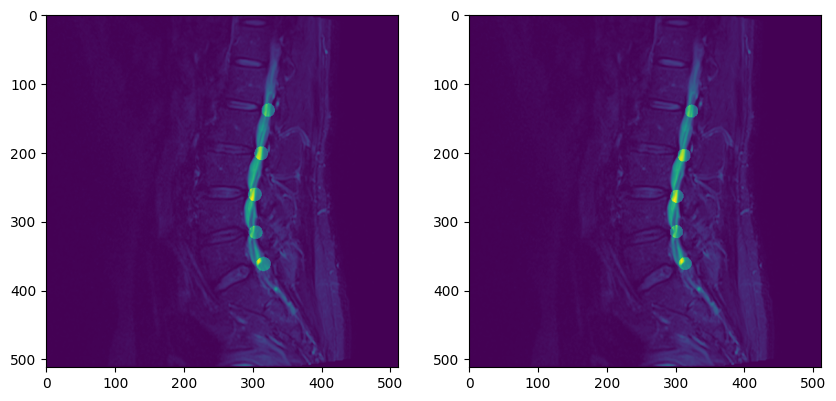

1161


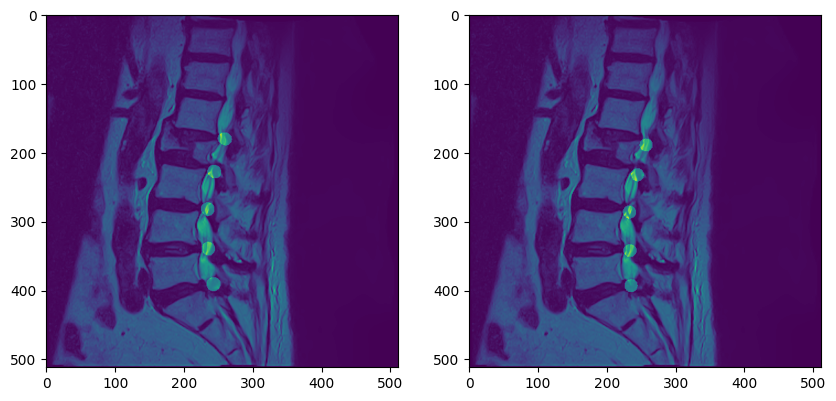

3845


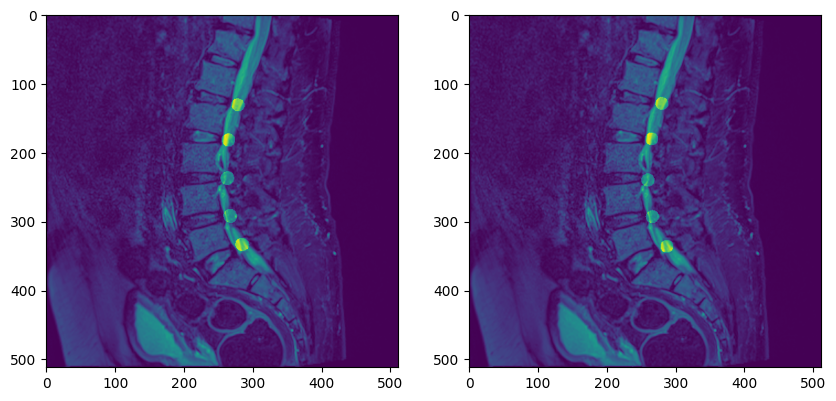

2703


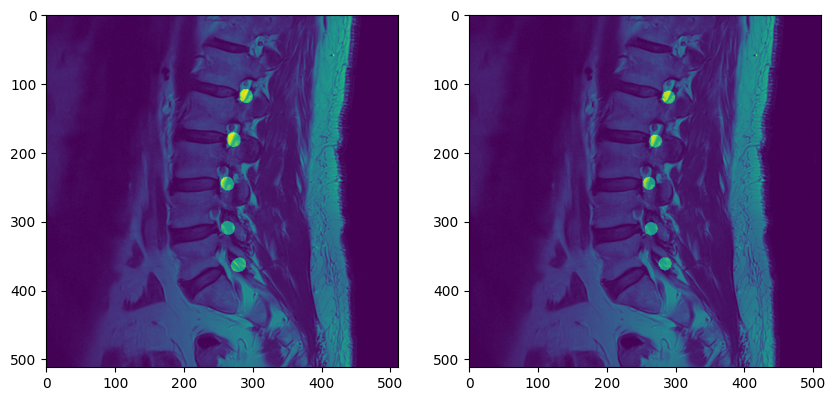

2640


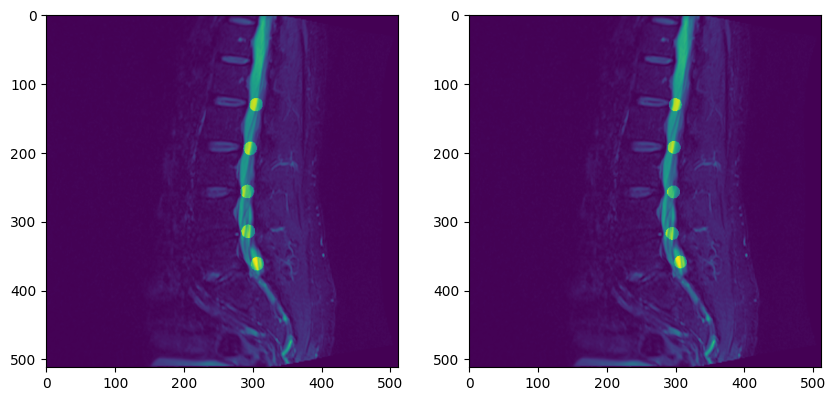

2324


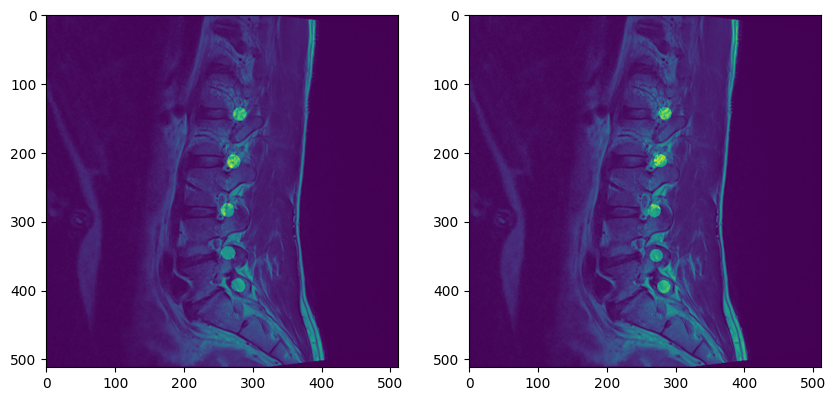

4163


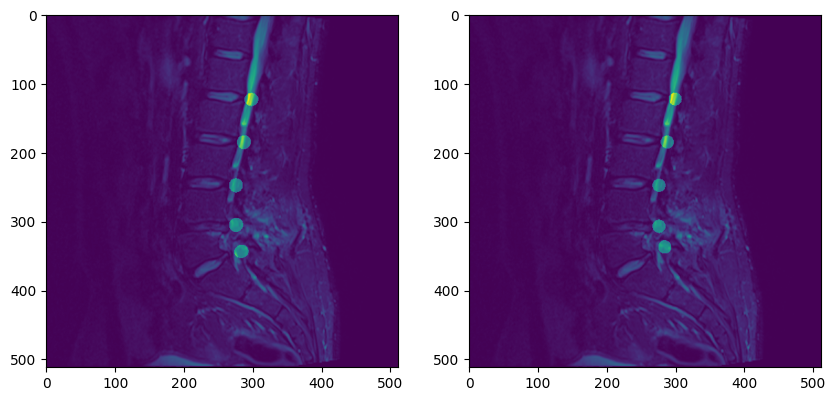

3989


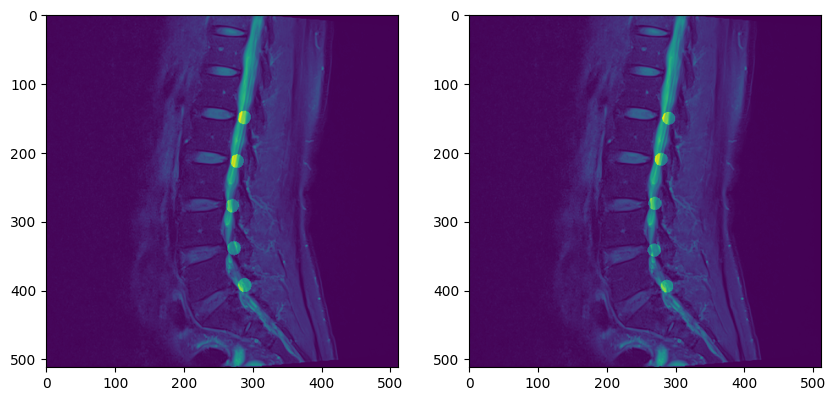

In [43]:
for k in range(20):
    i = np.random.randint(len(vds))
    print(i)
    image,centers = vds.__getitem__(np.random.randint(len(vds)))
    centers = centers[centers.isnan().sum(1) == 0]
#   Ideal heatmaps
    mask = idx_map - centers.view(len(centers),2,1,1).to(device)
    mask = (mask*mask).sum(1)
    mask = torch.exp(A*mask)
    mask = mask.sum(0)
    fig, axes = plt.subplots(1, 2, figsize=(10,10))
    axes[0].imshow(image.cpu()[0] + .5*(model(image.unsqueeze(0))[0].detach().cpu() > TH).sum(0))
    axes[1].imshow(image.cpu()[0] + .5*(mask.cpu() > TH))
    plt.show()

In [44]:
del model,vdf,vds
gc.collect()

28845